## 26x26のウエハに限定して機械学習させる
- データオーギュメンテーション（鏡映，回転を追加）

### import，入力データの読み込み

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/LSWMD.pkl


In [2]:
import os
from os.path import join
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

import numpy as np
import pandas as pd
import pickle
import copy
import cv2

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 


import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

datapath = join('data', 'wafer')

print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

MAKE_DATASET = False

using GPU: 0,1


Using TensorFlow backend.


['LSWMD.pkl']


### データについて

- データセットは811,457枚のウエハマップから構成されている．

- ウエハマップのそれぞれの列から得られる情報はないが，インスタンスごとにダイサイズが異なることがわかる．
- ウエハマップのダイサイズをチェックするための変数`WaferMapDim`を定義する．（縦，横の値）

In [3]:
if MAKE_DATASET:
    df=pd.read_pickle("../input/LSWMD.pkl")

    df = df.drop(['waferIndex'], axis = 1)

    def find_dim(x):
        dim0=np.size(x,axis=0)
        dim1=np.size(x,axis=1)
        return dim0,dim1
    df['waferMapDim']=df.waferMap.apply(find_dim)

- 不良パターンと学習orテストラベルを数値で表す．

In [4]:
if MAKE_DATASET:
    df['failureNum']=df.failureType
    df['trainTestNum']=df.trianTestLabel
    mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
    mapping_traintest={'Training':0,'Test':1}
    df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

    tol_wafers = df.shape[0]

    df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
    df_withlabel =df_withlabel.reset_index()
    df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
    df_withpattern = df_withpattern.reset_index()
    df_nonpattern = df[(df['failureNum']==8)]

### 26x26のデータに対して処理

In [5]:
if MAKE_DATASET:
    sub_df = df.loc[df['waferMapDim'] == (26, 26)]
    sub_wafer = sub_df['waferMap'].values

    sw = np.ones((1, 26, 26))
    label = list()

    for i in range(len(sub_df)):
        # skip null label
        if len(sub_df.iloc[i,:]['failureType']) == 0:
            continue
        sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
        label.append(sub_df.iloc[i,:]['failureType'][0][0])

    x = sw[1:]
    y = np.array(label).reshape((-1,1))

### xとyをファイルに保存

In [6]:
def pickle_dump(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj,f)

def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

if MAKE_DATASET:
    pickle_dump(x, './data/x2626.pickle')
    pickle_dump(y, './data/y2626.pickle')
    
if not MAKE_DATASET:
    x = pickle_load('./data/x2626.pickle')
    y = pickle_load('./data/y2626.pickle')

In [7]:
mask_x = np.zeros((24, 24))
dummy_x = cv2.resize(x[0], (24,24))
mask_x[dummy_x == 1] = 1 
mask_x[dummy_x == 2] = 1 
mask_x = mask_x.reshape((1, 24,24))

In [8]:
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


- 26x26のウエハが14366枚抽出できた．

- 最初のデータを可視化してみる．
- その前に，26x26のデータでおかしなものを表示

In [9]:
for i in range(len(x)):
    error = np.where((x[0] != x[i]) & ((x[0] == 0) | (x[i] == 0)))

- おかしなウエハは除去する

In [10]:
error_list = []
for i in range(len(x)):
    error = np.where((x[0] != x[i]) & ((x[0] == 0) | (x[i] == 0)))
    if len(error[0]) > 0:
        error_list.append(i)
x = np.delete(x, error_list, 0)
y = np.delete(y, error_list, 0)
print(x.shape)
print(y.shape)

(14350, 26, 26)
(14350, 1)


- 形が異なるウエハを削除したところ，14350枚となった．

In [11]:
x = x.reshape((-1, 26, 26, 1))
x.shape

(14350, 26, 26, 1)

In [12]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [13]:
faulty_case_dict = dict()

In [14]:
for i, f in enumerate(faulty_case) :
    print('{} : {}'.format(f, len(y[y==f])))
    faulty_case_dict[i] = f

Center : 90
Donut : 1
Edge-Loc : 289
Edge-Ring : 23
Loc : 297
Near-full : 16
Random : 74
Scratch : 71
none : 13489


- 14366枚の26x26ウエハの不良パターンは上記のようになっている．

In [15]:
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [16]:
new_x.shape

(14350, 26, 26, 3)

- new_xを(14366, 26, 26, 3)とし，最後の次元にはウエハの値(0, 1, 2)がそれぞれの値毎にベクトルとしてまとめられている．
- ウエハデータの各ピクセルは，0:ウエハなし，1:正常，2:不良を表す．

### 各ウエハにラベル付け

In [17]:
trials = 1
label_list = []
for i in range(new_x.shape[0]):
    label_dict = {'wafer_id':str(i).zfill(6), 'true_label':None, 'predict_label':None, 'augmentation':{'noise':0, 'rotation':0, 'inversion':0}, 'trials':trials}
    label_list.append(label_dict)

In [18]:
print(label_list[1])

{'wafer_id': '000001', 'true_label': None, 'predict_label': None, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 1}


### オートエンコーダで学習

#### エンコーダとデコーダのモデルを学習

- モデルの定義をする．

In [19]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

In [20]:
ae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 26, 26, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 13, 13, 64)        36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 26, 26, 3)         1731      
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
_______________________________________________________

- 層は
    - 入力層
    - 畳み込み層
    - プーリング層
    - 転置畳み込み層
    - アップサンプリング層

In [21]:
epoch=30
batch_size=1024

- 学習を開始する．
- `new_x`を`new_x`にエンコードしデコードする．

In [22]:
# start train
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=1)

Epoch 1/30
14350/14350 [==============================] - 1s 102us/step - loss: 0.1539
Epoch 2/30
14350/14350 [==============================] - 1s 38us/step - loss: 0.0951
Epoch 3/30
14350/14350 [==============================] - 1s 40us/step - loss: 0.0827
Epoch 4/30
14350/14350 [==============================] - 1s 40us/step - loss: 0.0718
Epoch 5/30
14350/14350 [==============================] - 1s 40us/step - loss: 0.0627
Epoch 6/30
14350/14350 [==============================] - 1s 40us/step - loss: 0.0558
Epoch 7/30
14350/14350 [==============================] - 1s 40us/step - loss: 0.0501
Epoch 8/30
14350/14350 [==============================] - 1s 41us/step - loss: 0.0448
Epoch 9/30
14350/14350 [==============================] - 1s 41us/step - loss: 0.0393
Epoch 10/30
14350/14350 [==============================] - 1s 40us/step - loss: 0.0344
Epoch 11/30
14350/14350 [==============================] - 1s 41us/step - loss: 0.0305
Epoch 12/30
14350/14350 [==========================

- エンコーダだけのモデルを定義する．

In [23]:
encoder = models.Model(input_tensor, latent_vector)

- デコーダだけのモデルを定義する．

In [24]:
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

- `encoder`を使って元のウエハ画像をエンコードする．

In [25]:
# Encode original faulty wafer
encoded_x = encoder.predict(new_x)

- エンコードされた潜伏的な不良ウエハにノイズを負荷する．

In [26]:
# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

- 元のウエハ画像

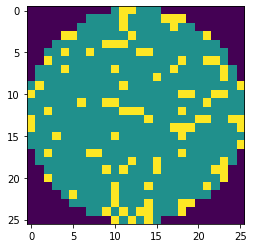

In [27]:
# check original faulty wafer data
plt.imshow(np.argmax(new_x[3], axis=2))

- ノイズが付加されたウエハ画像

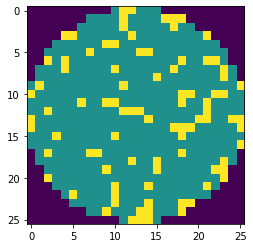

In [28]:
# check new noised faulty wafer data
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

In [29]:
# ノイズが1枚当たりいくつ入るのかを調べる
'''
noised_encoded_x.shape
noise = 0
size = 1000 #new_x.shape[0]
for i in range(size):
    noise += np.count_nonzero(np.argmax(decoder.predict(noised_encoded_x)[i], axis=2) - np.argmax(new_x[i], axis=2))
    print(i)
print(noise)
print(noise / size)
'''

'\nnoised_encoded_x.shape\nnoise = 0\nsize = 1000 #new_x.shape[0]\nfor i in range(size):\n    noise += np.count_nonzero(np.argmax(decoder.predict(noised_encoded_x)[i], axis=2) - np.argmax(new_x[i], axis=2))\n    print(i)\nprint(noise)\nprint(noise / size)\n'

- マスクの定義

In [30]:
# 0がウエハ領域，1が範囲外
mask = new_x[0, :, :, 0].copy()
#out_region = np.where(mask == 1.0)
#in_region = np.where(mask == 0.0)
#mask[out_region] = 0.0
#mask[in_region] = 1.0
#print(mask)

- 90度以外の回転

In [31]:
from PIL import Image, ImageOps
def rotation_pil_mask(img, degree):
    src = Image.fromarray(np.uint8(img))
    img_rotate = np.array(src.rotate(degree))
    
    #before
    '''
    plt.imshow(np.argmax(img_rotate, axis=2))
    plt.title("rotate " + str(degree) + " degree before")
    plt.show()
    '''
    
    #マスクの適用, 
    out_region = np.where((np.argmax(img_rotate, axis=2) != 0) & (mask > 0.0))
    img_rotate[out_region[0], out_region[1]] = np.array([1., 0., 0.])
    in_region = np.where((np.argmax(img_rotate, axis=2) == 0) & (mask == 0.0))
    img_rotate[in_region[0], in_region[1]] = np.array([0., 1., 0.])

    #after
    '''plt.imshow(np.argmax(img_rotate, axis=2))
    plt.title("rotate " + str(degree) + " degree after")
    plt.show()'''

    return img_rotate

# 上下方向の鏡映
def flip_pil_mask(img):
    src = Image.fromarray(np.uint8(img))
    img_flip = np.array(ImageOps.flip(src))
    
    #マスクの適用, 
    out_region = np.where((np.argmax(img_flip, axis=2) != 0) & (mask > 0.0))
    img_flip[out_region[0], out_region[1]] = np.array([1., 0., 0.])
    in_region = np.where((np.argmax(img_flip, axis=2) == 0) & (mask == 0.0))
    img_flip[in_region[0], in_region[1]] = np.array([0., 1., 0.])
    
    return img_flip

# 左右方向の鏡映
def mirror_pil_mask(img):
    src = Image.fromarray(np.uint8(img))
    img_mirror = np.array(ImageOps.mirror(src))
    
    #マスクの適用, 
    out_region = np.where((np.argmax(img_mirror, axis=2) != 0) & (mask > 0.0))
    img_mirror[out_region[0], out_region[1]] = np.array([1., 0., 0.])
    in_region = np.where((np.argmax(img_mirror, axis=2) == 0) & (mask == 0.0))
    img_mirror[in_region[0], in_region[1]] = np.array([0., 1., 0.])
    
    return img_mirror

In [32]:
# 回転の実験
'''
wafer = new_x[np.where(y=="Edge-Loc")[0]].reshape(len(np.where(y=="Edge-Loc")[0]), 26, 26, 3)
plt.imshow(np.argmax(wafer[0], axis=2))
plt.show()


# for i in range(19):
#     rotation_pil_mask(wafer[0], i*20)

plt.imshow(np.argmax(flip_pil_mask(wafer[0]), axis=2))
plt.show()

plt.imshow(np.argmax(mirror_pil_mask(wafer[0]), axis=2))
plt.show()

plt.imshow(np.argmax(flip_pil_mask(mirror_pil_mask(wafer[0])), axis=2))
plt.show()
'''

'\nwafer = new_x[np.where(y=="Edge-Loc")[0]].reshape(len(np.where(y=="Edge-Loc")[0]), 26, 26, 3)\nplt.imshow(np.argmax(wafer[0], axis=2))\nplt.show()\n\n\n# for i in range(19):\n#     rotation_pil_mask(wafer[0], i*20)\n\nplt.imshow(np.argmax(flip_pil_mask(wafer[0]), axis=2))\nplt.show()\n\nplt.imshow(np.argmax(mirror_pil_mask(wafer[0]), axis=2))\nplt.show()\n\nplt.imshow(np.argmax(flip_pil_mask(mirror_pil_mask(wafer[0])), axis=2))\nplt.show()\n'

### データオーギュメンテーション

- データオーギュメンテーションを行う関数を定義する．
- 鏡映，回転を行う

In [33]:
shawon = True
rotation_num = 3
inversion = False
pattern_num = 2000

In [34]:
# augment function define (add rotate, flip)
def gen_data(wafer, label):
    global label_list
    # Encode input wafer
    #encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    aug_x = np.zeros((1, 26, 26, 3))
    
    augmentation_dict = []
    
    ite = rotation_num if label != 'none' else 1
    
    if not shawon:
        for i in range(len(wafer)):
            for j in range(ite):
    #             rotatedata = wafer[i]
                angle = int(180 / ite)
                rotatedata = rotation_pil_mask(wafer[i], j * angle)
                rotatedata = rotatedata.reshape(1, 26, 26, 3)
                augmentation_dict.append({'wafer_id':str(label_list[i]['wafer_id']).zfill(6), 'true_label':label_list[i]['true_label'], 'predict_label':None, 'augmentation':{'noise':0, 'rotation':angle, 'inversion':0}, 'trials':trials})

                if inversion:
                    flipdata = flip_pil_mask(rotatedata)
                    flipmirrordata = mirror_pil_mask(flipdata)
                    mirrordata = mirror_pil_mask(rotatedata)
                    flipdata = flipdata.reshape(1, 26, 26, 3)
                    flipmirrordata = flipmirrordata.reshape(1, 26, 26, 3)
                    mirrordata = mirrordata.reshape(1, 26, 26, 3)
                    aug_x = np.concatenate((aug_x, rotatedata, flipdata, flipmirrordata, mirrordata), axis = 0)
                    augmentation_dict.append({'wafer_id':str(label_list[i]['wafer_id']).zfill(6), 'true_label':label_list[i]['true_label'], 'predict_label':None, 'augmentation':{'noise':0, 'rotation':angle, 'inversion':1}, 'trials':trials})
                    augmentation_dict.append({'wafer_id':str(label_list[i]['wafer_id']).zfill(6), 'true_label':label_list[i]['true_label'], 'predict_label':None, 'augmentation':{'noise':0, 'rotation':angle, 'inversion':2}, 'trials':trials})
                    augmentation_dict.append({'wafer_id':str(label_list[i]['wafer_id']).zfill(6), 'true_label':label_list[i]['true_label'], 'predict_label':None, 'augmentation':{'noise':0, 'rotation':angle, 'inversion':3}, 'trials':trials})
                else:
                    aug_x = np.concatenate((aug_x, rotatedata), axis = 0)

        aug_x = aug_x[1:]
        encoded_x = encoder.predict(aug_x)
    
    else:
        encoded_x = encoder.predict(wafer)
        for i in range(len(wafer)):
            augmentation_dict.append({'wafer_id':str(label_list[i]['wafer_id']).zfill(6), 'true_label':label_list[i]['true_label'], 'predict_label':None, 'augmentation':{'noise':0, 'rotation':0, 'inversion':0}, 'trials':trials})
    print(encoded_x.shape)
        
    # Shawon's experiment 2000
    if label != 'none':
        for i in range((pattern_num//len(encoded_x)) + 1):
            noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
            noised_gen_x = decoder.predict(noised_encoded_x)
            gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
            label_list_before = copy.copy(augmentation_dict)
            for j in range(len(encoded_x)):
                label_list_before[j]['augmentation']['noise'] = i+1
            label_list += label_list_before
            import pprint
            pprint.pprint(label_list_before)
    else:
        gen_x = aug_x
        
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

- データオーギュメンテーション（ノイズ付加）したものが適切か調べる

一番左が元画像
右がデータオーギュメンテーション後

In [35]:
# backup
bu_new_x = new_x.copy()
bu_y = y.copy()

In [36]:
# new_x = bu_new_x.copy()
# y = bu_y.copy()
# gen_x = []

- 不良ラベルが付いているデータに対してデータオーギュメンテーションを行う．

In [37]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

(90, 13, 13, 64)
[{'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': N

  'wafer_id': '000068'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000069'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000070'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000071'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000072'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000073'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000074'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_l

  'true_label': None,
  'wafer_id': '000021'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000022'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000023'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000024'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000025'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000026'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000027'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotat

[{'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 

  'true_label': None,
  'wafer_id': '000089'}]
[{'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotat

  'true_label': None,
  'wafer_id': '000038'},
 {'augmentation': {'inversion': 0, 'noise': 8, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000039'},
 {'augmentation': {'inversion': 0, 'noise': 8, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000040'},
 {'augmentation': {'inversion': 0, 'noise': 8, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000041'},
 {'augmentation': {'inversion': 0, 'noise': 8, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000042'},
 {'augmentation': {'inversion': 0, 'noise': 8, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000043'},
 {'augmentation': {'inversion': 0, 'noise': 8, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000044'},
 {'augmentation': {'inversion': 0, 'noise': 8, 'rotat

[{'augmentation': {'inversion': 0, 'noise': 10, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 10, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 10, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 10, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 10, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 10, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 10, 'rotation': 0},
  'predict_label': None,
  'tr

 {'augmentation': {'inversion': 0, 'noise': 11, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000073'},
 {'augmentation': {'inversion': 0, 'noise': 11, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000074'},
 {'augmentation': {'inversion': 0, 'noise': 11, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000075'},
 {'augmentation': {'inversion': 0, 'noise': 11, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000076'},
 {'augmentation': {'inversion': 0, 'noise': 11, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000077'},
 {'augmentation': {'inversion': 0, 'noise': 11, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000078'},
 {'augmentation': {'inversion': 0, 'noise': 11, 'rotation': 0},
  'predict_label': None,
  'tr

  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000022'},
 {'augmentation': {'inversion': 0, 'noise': 13, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000023'},
 {'augmentation': {'inversion': 0, 'noise': 13, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000024'},
 {'augmentation': {'inversion': 0, 'noise': 13, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000025'},
 {'augmentation': {'inversion': 0, 'noise': 13, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000026'},
 {'augmentation': {'inversion': 0, 'noise': 13, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000027'},
 {'augmentation': {'inversion': 0, 'noise': 13, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000028'},
 {'augm

[{'augmentation': {'inversion': 0, 'noise': 15, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 15, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 15, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 15, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 15, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 15, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 15, 'rotation': 0},
  'predict_label': None,
  'tr

  'trials': 1,
  'true_label': None,
  'wafer_id': '000078'},
 {'augmentation': {'inversion': 0, 'noise': 16, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000079'},
 {'augmentation': {'inversion': 0, 'noise': 16, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000080'},
 {'augmentation': {'inversion': 0, 'noise': 16, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000081'},
 {'augmentation': {'inversion': 0, 'noise': 16, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000082'},
 {'augmentation': {'inversion': 0, 'noise': 16, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000083'},
 {'augmentation': {'inversion': 0, 'noise': 16, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000084'},
 {'augmentation': {'inversion': 

 {'augmentation': {'inversion': 0, 'noise': 18, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 18, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 18, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 18, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 18, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000006'},
 {'augmentation': {'inversion': 0, 'noise': 18, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000007'},
 {'augmentation': {'inversion': 0, 'noise': 18, 'rotation': 0},
  'predict_label': None,
  'tr

[{'augmentation': {'inversion': 0, 'noise': 20, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 20, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 20, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 20, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 20, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 20, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 20, 'rotation': 0},
  'predict_label': None,
  'tr

[{'augmentation': {'inversion': 0, 'noise': 22, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 22, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 22, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 22, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 22, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 22, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 22, 'rotation': 0},
  'predict_label': None,
  'tr

  'wafer_id': '000087'},
 {'augmentation': {'inversion': 0, 'noise': 23, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000088'},
 {'augmentation': {'inversion': 0, 'noise': 23, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000089'}]
(1, 13, 13, 64)
[{'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 4, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 5, 'rotation'

  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 93, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 94, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 95, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 96, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 97, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 98, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augm

[{'augmentation': {'inversion': 0, 'noise': 195, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 196, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 197, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 198, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 199, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 200, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 201, 'rotation': 0},
  'predict_label': None

[{'augmentation': {'inversion': 0, 'noise': 289, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 290, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 291, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 292, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 293, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 294, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 295, 'rotation': 0},
  'predict_label': None

[{'augmentation': {'inversion': 0, 'noise': 382, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 383, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 384, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 385, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 386, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 387, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 388, 'rotation': 0},
  'predict_label': None

[{'augmentation': {'inversion': 0, 'noise': 478, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 479, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 480, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 481, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 482, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 483, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 484, 'rotation': 0},
  'predict_label': None

[{'augmentation': {'inversion': 0, 'noise': 557, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 558, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 559, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 560, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 561, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 562, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 563, 'rotation': 0},
  'predict_label': None

[{'augmentation': {'inversion': 0, 'noise': 637, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 638, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 639, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 640, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 641, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 642, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 643, 'rotation': 0},
  'predict_label': None

[{'augmentation': {'inversion': 0, 'noise': 715, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 716, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 717, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 718, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 719, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 720, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 721, 'rotation': 0},
  'predict_label': None

[{'augmentation': {'inversion': 0, 'noise': 785, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 786, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 787, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 788, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 789, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 790, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 791, 'rotation': 0},
  'predict_label': None

[{'augmentation': {'inversion': 0, 'noise': 855, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 856, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 857, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 858, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 859, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 860, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 861, 'rotation': 0},
  'predict_label': None

[{'augmentation': {'inversion': 0, 'noise': 922, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 923, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 924, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 925, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 926, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 927, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 928, 'rotation': 0},
  'predict_label': None

[{'augmentation': {'inversion': 0, 'noise': 985, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 986, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 987, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 988, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 989, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 990, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 991, 'rotation': 0},
  'predict_label': None

[{'augmentation': {'inversion': 0, 'noise': 1048, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1049, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1050, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1051, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1052, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1053, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1054, 'rotation': 0},
  'predict_label

[{'augmentation': {'inversion': 0, 'noise': 1109, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1110, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1111, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1112, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1113, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1114, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1115, 'rotation': 0},
  'predict_label

[{'augmentation': {'inversion': 0, 'noise': 1169, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1170, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1171, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1172, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1173, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1174, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1175, 'rotation': 0},
  'predict_label

[{'augmentation': {'inversion': 0, 'noise': 1227, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1228, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1229, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1230, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1231, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1232, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1233, 'rotation': 0},
  'predict_label

[{'augmentation': {'inversion': 0, 'noise': 1283, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1284, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1285, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1286, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1287, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1288, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1289, 'rotation': 0},
  'predict_label

[{'augmentation': {'inversion': 0, 'noise': 1338, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1339, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1340, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1341, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1342, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1343, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1344, 'rotation': 0},
  'predict_label

  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1394, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1395, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1396, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1397, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1398, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1399, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'

[{'augmentation': {'inversion': 0, 'noise': 1449, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1450, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1451, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1452, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1453, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1454, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1455, 'rotation': 0},
  'predict_label

[{'augmentation': {'inversion': 0, 'noise': 1503, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1504, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1505, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1506, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1507, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1508, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1509, 'rotation': 0},
  'predict_label

[{'augmentation': {'inversion': 0, 'noise': 1578, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1579, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1580, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1581, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1582, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1583, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1584, 'rotation': 0},
  'predict_label

[{'augmentation': {'inversion': 0, 'noise': 1656, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1657, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1658, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1659, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1660, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1661, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1662, 'rotation': 0},
  'predict_label

[{'augmentation': {'inversion': 0, 'noise': 1731, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1732, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1733, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1734, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1735, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1736, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1737, 'rotation': 0},
  'predict_label

[{'augmentation': {'inversion': 0, 'noise': 1809, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1810, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1811, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1812, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1813, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1814, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1815, 'rotation': 0},
  'predict_label

[{'augmentation': {'inversion': 0, 'noise': 1883, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1884, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1885, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1886, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1887, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1888, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1889, 'rotation': 0},
  'predict_label

[{'augmentation': {'inversion': 0, 'noise': 1957, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1958, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1959, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1960, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1961, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1962, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'}]
[{'augmentation': {'inversion': 0, 'noise': 1963, 'rotation': 0},
  'predict_label

  'trials': 1,
  'true_label': None,
  'wafer_id': '000226'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000227'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000228'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000229'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000230'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000231'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000232'},
 {'augmentation': {'inversion': 0, 'no

[{'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 

  'wafer_id': '000235'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000236'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000237'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000238'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000239'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000240'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000241'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_l

  'true_label': None,
  'wafer_id': '000015'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000016'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000017'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000018'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000019'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000020'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000021'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotat

  'true_label': None,
  'wafer_id': '000223'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000224'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000225'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000226'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000227'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000228'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000229'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotat

[{'augmentation': {'inversion': 0, 'noise': 4, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 4, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 4, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 4, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 4, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 4, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 4, 'rotation': 0},
  'predict_label': None,
  'trials': 

  'true_label': None,
  'wafer_id': '000248'},
 {'augmentation': {'inversion': 0, 'noise': 4, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000249'},
 {'augmentation': {'inversion': 0, 'noise': 4, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000250'},
 {'augmentation': {'inversion': 0, 'noise': 4, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000251'},
 {'augmentation': {'inversion': 0, 'noise': 4, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000252'},
 {'augmentation': {'inversion': 0, 'noise': 4, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000253'},
 {'augmentation': {'inversion': 0, 'noise': 4, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000254'},
 {'augmentation': {'inversion': 0, 'noise': 4, 'rotat

  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000047'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000048'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000049'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000050'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000051'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000052'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000053'},
 {'augmentati

  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000270'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000271'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000272'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000273'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000274'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000275'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000276'},
 {'augmentati

  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000047'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000048'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000049'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000050'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000051'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000052'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000053'},
 {'augmentati

  'true_label': None,
  'wafer_id': '000267'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000268'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000269'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000270'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000271'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000272'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000273'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotat

  'true_label': None,
  'wafer_id': '000077'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000078'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000079'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000080'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000081'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000082'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000083'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotat

  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000272'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000273'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000274'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000275'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000276'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000277'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000278'},
 {'augmentati

[{'augmentation': {'inversion': 0, 'noise': 9, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 9, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 9, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 9, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 9, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 9, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 9, 'rotation': 0},
  'predict_label': None,
  'trials': 

[{'augmentation': {'inversion': 0, 'noise': 16, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 16, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 16, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 16, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 16, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 16, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 16, 'rotation': 0},
  'predict_label': None,
  'tr

  'wafer_id': '000008'},
 {'augmentation': {'inversion': 0, 'noise': 21, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000009'},
 {'augmentation': {'inversion': 0, 'noise': 21, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000010'},
 {'augmentation': {'inversion': 0, 'noise': 21, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000011'},
 {'augmentation': {'inversion': 0, 'noise': 21, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000012'},
 {'augmentation': {'inversion': 0, 'noise': 21, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000013'},
 {'augmentation': {'inversion': 0, 'noise': 21, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000014'},
 {'augmentation': {'inversion': 0, 'noise': 21, 'rotation': 0},
  'pr

[{'augmentation': {'inversion': 0, 'noise': 27, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 27, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 27, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 27, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 27, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 27, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 27, 'rotation': 0},
  'predict_label': None,
  'tr

[{'augmentation': {'inversion': 0, 'noise': 33, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 33, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 33, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 33, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 33, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 33, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 33, 'rotation': 0},
  'predict_label': None,
  'tr

[{'augmentation': {'inversion': 0, 'noise': 39, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 39, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 39, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 39, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 39, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 39, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 39, 'rotation': 0},
  'predict_label': None,
  'tr

[{'augmentation': {'inversion': 0, 'noise': 46, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 46, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 46, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 46, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 46, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 46, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 46, 'rotation': 0},
  'predict_label': None,
  'tr

[{'augmentation': {'inversion': 0, 'noise': 52, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 52, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 52, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 52, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 52, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 52, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 52, 'rotation': 0},
  'predict_label': None,
  'tr

[{'augmentation': {'inversion': 0, 'noise': 58, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 58, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 58, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 58, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 58, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 58, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 58, 'rotation': 0},
  'predict_label': None,
  'tr

[{'augmentation': {'inversion': 0, 'noise': 64, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 64, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 64, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 64, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 64, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 64, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 64, 'rotation': 0},
  'predict_label': None,
  'tr

  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 69, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 69, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 69, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 69, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 69, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 69, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000006'},
 {'augm

  'trials': 1,
  'true_label': None,
  'wafer_id': '000022'}]
[{'augmentation': {'inversion': 0, 'noise': 75, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 75, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 75, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 75, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 75, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 75, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 

[{'augmentation': {'inversion': 0, 'noise': 81, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 81, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 81, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 81, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 81, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 81, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 81, 'rotation': 0},
  'predict_label': None,
  'tr

[{'augmentation': {'inversion': 0, 'noise': 87, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 87, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 87, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 87, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 87, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 87, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 87, 'rotation': 0},
  'predict_label': None,
  'tr

 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000240'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000241'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000242'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000243'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000244'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000245'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 

  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000006'},
 {'augmentati

 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000220'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000221'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000222'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000223'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000224'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000225'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 

[{'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 

  'wafer_id': '000255'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000256'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000257'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000258'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000259'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000260'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000261'},
 {'augmentation': {'inversion': 0, 'noise': 3, 'rotation': 0},
  'predict_l

  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000226'},
 {'augmentation': {'inversion': 0, 'noise': 4, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000227'},
 {'augmentation': {'inversion': 0, 'noise': 4, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000228'},
 {'augmentation': {'inversion': 0, 'noise': 4, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000229'},
 {'augmentation': {'inversion': 0, 'noise': 4, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000230'},
 {'augmentation': {'inversion': 0, 'noise': 4, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000231'},
 {'augmentation': {'inversion': 0, 'noise': 4, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000232'},
 {'augmentati

[{'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 

  'wafer_id': '000206'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000207'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000208'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000209'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000210'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000211'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000212'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_l

[{'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 

  'trials': 1,
  'true_label': None,
  'wafer_id': '000220'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000221'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000222'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000223'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000224'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000225'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000226'},
 {'augmentation': {'inversion': 0, 'no

[{'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 

 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000223'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000224'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000225'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000226'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000227'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000228'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 

[{'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 

  'true_label': None,
  'wafer_id': '000014'},
 {'augmentation': {'inversion': 0, 'noise': 9, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000015'}]
[{'augmentation': {'inversion': 0, 'noise': 10, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 10, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 10, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 10, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 10, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 10, 

[{'augmentation': {'inversion': 0, 'noise': 18, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 18, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 18, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 18, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 18, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 18, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 18, 'rotation': 0},
  'predict_label': None,
  'tr

[{'augmentation': {'inversion': 0, 'noise': 27, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 27, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 27, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 27, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 27, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 27, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 27, 'rotation': 0},
  'predict_label': None,
  'tr

[{'augmentation': {'inversion': 0, 'noise': 35, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 35, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 35, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 35, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 35, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 35, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 35, 'rotation': 0},
  'predict_label': None,
  'tr

  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 42, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 42, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000006'},
 {'augmentation': {'inversion': 0, 'noise': 42, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000007'},
 {'augmentation': {'inversion': 0, 'noise': 42, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000008'},
 {'augmentation': {'inversion': 0, 'noise': 42, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000009'},
 {'augmentation': {'inversion': 0, 'noise': 42, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000010'},
 {'augmentation': {'inversion': 0, 'noise': 42,

[{'augmentation': {'inversion': 0, 'noise': 51, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 51, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 51, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 51, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 51, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 51, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 51, 'rotation': 0},
  'predict_label': None,
  'tr

[{'augmentation': {'inversion': 0, 'noise': 59, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 59, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 59, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 59, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 59, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 59, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 59, 'rotation': 0},
  'predict_label': None,
  'tr

[{'augmentation': {'inversion': 0, 'noise': 67, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 67, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 67, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 67, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 67, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 67, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 67, 'rotation': 0},
  'predict_label': None,
  'tr

[{'augmentation': {'inversion': 0, 'noise': 75, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 75, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 75, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 75, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 75, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 75, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 75, 'rotation': 0},
  'predict_label': None,
  'tr

  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000014'},
 {'augmentation': {'inversion': 0, 'noise': 82, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000015'}]
[{'augmentation': {'inversion': 0, 'noise': 83, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 83, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 83, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 83, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 83, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augm

  'trials': 1,
  'true_label': None,
  'wafer_id': '000007'},
 {'augmentation': {'inversion': 0, 'noise': 89, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000008'},
 {'augmentation': {'inversion': 0, 'noise': 89, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000009'},
 {'augmentation': {'inversion': 0, 'noise': 89, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000010'},
 {'augmentation': {'inversion': 0, 'noise': 89, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000011'},
 {'augmentation': {'inversion': 0, 'noise': 89, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000012'},
 {'augmentation': {'inversion': 0, 'noise': 89, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000013'},
 {'augmentation': {'inversion': 

  'wafer_id': '000006'},
 {'augmentation': {'inversion': 0, 'noise': 96, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000007'},
 {'augmentation': {'inversion': 0, 'noise': 96, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000008'},
 {'augmentation': {'inversion': 0, 'noise': 96, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000009'},
 {'augmentation': {'inversion': 0, 'noise': 96, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000010'},
 {'augmentation': {'inversion': 0, 'noise': 96, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000011'},
 {'augmentation': {'inversion': 0, 'noise': 96, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000012'},
 {'augmentation': {'inversion': 0, 'noise': 96, 'rotation': 0},
  'pr

[{'augmentation': {'inversion': 0, 'noise': 104, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 104, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 104, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 104, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 104, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 104, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 104, 'rotation': 0},
  'predict_label': None

[{'augmentation': {'inversion': 0, 'noise': 111, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 111, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 111, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 111, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 111, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 111, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 111, 'rotation': 0},
  'predict_label': None

[{'augmentation': {'inversion': 0, 'noise': 118, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 118, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 118, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 118, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 118, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 118, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 118, 'rotation': 0},
  'predict_label': None

  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000010'},
 {'augmentation': {'inversion': 0, 'noise': 126, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000011'},
 {'augmentation': {'inversion': 0, 'noise': 126, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000012'},
 {'augmentation': {'inversion': 0, 'noise': 126, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000013'},
 {'augmentation': {'inversion': 0, 'noise': 126, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000014'},
 {'augmentation': {'inversion': 0, 'noise': 126, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000015'}]
(74, 13, 13, 64)
[{'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id

  'trials': 1,
  'true_label': None,
  'wafer_id': '000073'}]
[{'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'no

[{'augmentation': {'inversion': 0, 'noise': 4, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 4, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 4, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 4, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 4, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 4, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 4, 'rotation': 0},
  'predict_label': None,
  'trials': 

[{'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 6, 'rotation': 0},
  'predict_label': None,
  'trials': 

[{'augmentation': {'inversion': 0, 'noise': 8, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 8, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 8, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 8, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 8, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 8, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 8, 'rotation': 0},
  'predict_label': None,
  'trials': 

[{'augmentation': {'inversion': 0, 'noise': 10, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 10, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 10, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 10, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 10, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 10, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 10, 'rotation': 0},
  'predict_label': None,
  'tr

[{'augmentation': {'inversion': 0, 'noise': 12, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 12, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 12, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 12, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 12, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 12, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 12, 'rotation': 0},
  'predict_label': None,
  'tr

[{'augmentation': {'inversion': 0, 'noise': 14, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 14, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 14, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 14, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 14, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 14, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 14, 'rotation': 0},
  'predict_label': None,
  'tr

  'wafer_id': '000042'},
 {'augmentation': {'inversion': 0, 'noise': 16, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000043'},
 {'augmentation': {'inversion': 0, 'noise': 16, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000044'},
 {'augmentation': {'inversion': 0, 'noise': 16, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000045'},
 {'augmentation': {'inversion': 0, 'noise': 16, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000046'},
 {'augmentation': {'inversion': 0, 'noise': 16, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000047'},
 {'augmentation': {'inversion': 0, 'noise': 16, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000048'},
 {'augmentation': {'inversion': 0, 'noise': 16, 'rotation': 0},
  'pr

[{'augmentation': {'inversion': 0, 'noise': 18, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 18, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 18, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 18, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 18, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 18, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 18, 'rotation': 0},
  'predict_label': None,
  'tr

[{'augmentation': {'inversion': 0, 'noise': 20, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 20, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 20, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 20, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 20, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 20, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 20, 'rotation': 0},
  'predict_label': None,
  'tr

[{'augmentation': {'inversion': 0, 'noise': 22, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 22, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 22, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 22, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 22, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 22, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 22, 'rotation': 0},
  'predict_label': None,
  'tr

[{'augmentation': {'inversion': 0, 'noise': 24, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 24, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 24, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 24, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 24, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 24, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 24, 'rotation': 0},
  'predict_label': None,
  'tr

[{'augmentation': {'inversion': 0, 'noise': 26, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 26, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 26, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 26, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 26, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 26, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 26, 'rotation': 0},
  'predict_label': None,
  'tr

[{'augmentation': {'inversion': 0, 'noise': 28, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 28, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 28, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 28, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 28, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 28, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 28, 'rotation': 0},
  'predict_label': None,
  'tr

(71, 13, 13, 64)
[{'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 1, 'rotation': 0},
  'predict_label': N

 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000053'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000054'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000055'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000056'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000057'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000058'},
 {'augmentation': {'inversion': 0, 'noise': 2, 'rotation': 0},
  'predict_label': None,
  'trials': 

[{'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 5, 'rotation': 0},
  'predict_label': None,
  'trials': 

[{'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 7, 'rotation': 0},
  'predict_label': None,
  'trials': 

[{'augmentation': {'inversion': 0, 'noise': 9, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 9, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 9, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 9, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 9, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 9, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 9, 'rotation': 0},
  'predict_label': None,
  'trials': 

[{'augmentation': {'inversion': 0, 'noise': 11, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 11, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 11, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 11, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 11, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 11, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 11, 'rotation': 0},
  'predict_label': None,
  'tr

  'true_label': None,
  'wafer_id': '000034'},
 {'augmentation': {'inversion': 0, 'noise': 13, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000035'},
 {'augmentation': {'inversion': 0, 'noise': 13, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000036'},
 {'augmentation': {'inversion': 0, 'noise': 13, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000037'},
 {'augmentation': {'inversion': 0, 'noise': 13, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000038'},
 {'augmentation': {'inversion': 0, 'noise': 13, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000039'},
 {'augmentation': {'inversion': 0, 'noise': 13, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000040'},
 {'augmentation': {'inversion': 0, 'noise': 13,

  'wafer_id': '000039'},
 {'augmentation': {'inversion': 0, 'noise': 15, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000040'},
 {'augmentation': {'inversion': 0, 'noise': 15, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000041'},
 {'augmentation': {'inversion': 0, 'noise': 15, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000042'},
 {'augmentation': {'inversion': 0, 'noise': 15, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000043'},
 {'augmentation': {'inversion': 0, 'noise': 15, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000044'},
 {'augmentation': {'inversion': 0, 'noise': 15, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000045'},
 {'augmentation': {'inversion': 0, 'noise': 15, 'rotation': 0},
  'pr

 {'augmentation': {'inversion': 0, 'noise': 17, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000035'},
 {'augmentation': {'inversion': 0, 'noise': 17, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000036'},
 {'augmentation': {'inversion': 0, 'noise': 17, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000037'},
 {'augmentation': {'inversion': 0, 'noise': 17, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000038'},
 {'augmentation': {'inversion': 0, 'noise': 17, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000039'},
 {'augmentation': {'inversion': 0, 'noise': 17, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000040'},
 {'augmentation': {'inversion': 0, 'noise': 17, 'rotation': 0},
  'predict_label': None,
  'tr

  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000034'},
 {'augmentation': {'inversion': 0, 'noise': 19, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000035'},
 {'augmentation': {'inversion': 0, 'noise': 19, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000036'},
 {'augmentation': {'inversion': 0, 'noise': 19, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000037'},
 {'augmentation': {'inversion': 0, 'noise': 19, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000038'},
 {'augmentation': {'inversion': 0, 'noise': 19, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000039'},
 {'augmentation': {'inversion': 0, 'noise': 19, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000040'},
 {'augm

  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000036'},
 {'augmentation': {'inversion': 0, 'noise': 21, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000037'},
 {'augmentation': {'inversion': 0, 'noise': 21, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000038'},
 {'augmentation': {'inversion': 0, 'noise': 21, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000039'},
 {'augmentation': {'inversion': 0, 'noise': 21, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000040'},
 {'augmentation': {'inversion': 0, 'noise': 21, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000041'},
 {'augmentation': {'inversion': 0, 'noise': 21, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000042'},
 {'augm

  'wafer_id': '000027'},
 {'augmentation': {'inversion': 0, 'noise': 23, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000028'},
 {'augmentation': {'inversion': 0, 'noise': 23, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000029'},
 {'augmentation': {'inversion': 0, 'noise': 23, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000030'},
 {'augmentation': {'inversion': 0, 'noise': 23, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000031'},
 {'augmentation': {'inversion': 0, 'noise': 23, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000032'},
 {'augmentation': {'inversion': 0, 'noise': 23, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000033'},
 {'augmentation': {'inversion': 0, 'noise': 23, 'rotation': 0},
  'pr

[{'augmentation': {'inversion': 0, 'noise': 25, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 25, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 25, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 25, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 25, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 25, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 25, 'rotation': 0},
  'predict_label': None,
  'tr

  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000020'},
 {'augmentation': {'inversion': 0, 'noise': 27, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000021'},
 {'augmentation': {'inversion': 0, 'noise': 27, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000022'},
 {'augmentation': {'inversion': 0, 'noise': 27, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000023'},
 {'augmentation': {'inversion': 0, 'noise': 27, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000024'},
 {'augmentation': {'inversion': 0, 'noise': 27, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000025'},
 {'augmentation': {'inversion': 0, 'noise': 27, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000026'},
 {'augm

[{'augmentation': {'inversion': 0, 'noise': 29, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 29, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000001'},
 {'augmentation': {'inversion': 0, 'noise': 29, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000002'},
 {'augmentation': {'inversion': 0, 'noise': 29, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000003'},
 {'augmentation': {'inversion': 0, 'noise': 29, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000004'},
 {'augmentation': {'inversion': 0, 'noise': 29, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000005'},
 {'augmentation': {'inversion': 0, 'noise': 29, 'rotation': 0},
  'predict_label': None,
  'tr

In [38]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

After Generate new_x shape : (30671, 26, 26, 3), new_y shape : (30671, 1)


In [39]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))
new_y = y

Center : 2160
Donut : 2002
Edge-Loc : 2312
Edge-Ring : 2024
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2130
none : 13489


In [40]:
if shawon:
    none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]
    new_x = np.delete(new_x, none_idx, axis=0)
    new_y = np.delete(y, none_idx, axis=0)
    for i in sorted(none_idx.tolist(), reverse=True):
        label_list.pop(i)
#     label_list = 
    print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))
    for f in faulty_case :
        print('{} : {}'.format(f, len(new_y[new_y==f])))

After Delete "none" class new_x shape : (19671, 26, 26, 3), new_y shape : (19671, 1)
Center : 2160
Donut : 2002
Edge-Loc : 2312
Edge-Ring : 2024
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2130
none : 2489


In [41]:
import pprint
pprint.pprint(label_list[0:1000])

[{'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000000'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000006'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000013'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000016'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000019'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000021'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 

 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000288'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000291'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000294'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000298'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000302'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000303'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 

  'wafer_id': '000917'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000919'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000920'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000922'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000930'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000933'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '000934'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_l

  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '001494'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '001506'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '001511'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '001514'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '001520'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '001523'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '001524'},
 {'augmentati

  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '002118'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '002123'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '002124'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '002126'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '002128'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '002136'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '002140'},
 {'augmentati

  'wafer_id': '003103'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '003106'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '003108'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '003111'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '003117'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '003119'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '003124'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_l

  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '003400'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '003407'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '003408'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '003412'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '003413'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '003415'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '003425'},
 {'augmentati

  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '004207'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '004211'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '004213'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '004214'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '004218'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '004221'},
 {'augmentation': {'inversion': 0, 'noise': 0, 'rotation': 0},
  'predict_label': None,
  'trials': 1,
  'true_label': None,
  'wafer_id': '004234'},
 {'augmentati

### ノイズ付加後もマスクで直す

In [42]:
backup_new_x = new_x.copy()
backup_new_y = new_y.copy()

In [43]:
if not shawon:
    count = 0
    for i in range(len(new_x)):
        error = np.where((np.argmax(new_x[0], axis=2) != np.argmax(new_x[i], axis=2)) & (np.argmax(new_x[0], axis=2) == 0))
        if len(error[0]) > 0:
            #print(str(i) + "error")
            #print(error)
            count += 1
    print(count)

    for i in range(len(new_x)):
        #マスクの適用, 
        out_region = np.where((np.argmax(new_x[i], axis=2) != 0) & (mask > 0.0))
        new_x[i, out_region[0], out_region[1]] = np.array([1., 0., 0.])
        in_region = np.where((np.argmax(new_x[i], axis=2) == 0) & (mask == 0.0))
        new_x[i, in_region[0], in_region[1]] = np.array([0., 1., 0.])

    count = 0
    for i in range(len(new_x)):
        error = np.where((np.argmax(new_x[0], axis=2) != np.argmax(new_x[i], axis=2)) & (np.argmax(new_x[0], axis=2) == 0))
        if len(error[0]) > 0:
            #print(str(i) + "error")
            #print(error)
            count += 1
    print(count)


- データオーギュメンテーションを行った結果，各不良データごとに約40000枚に増えた．
- 合計は368112枚となった．

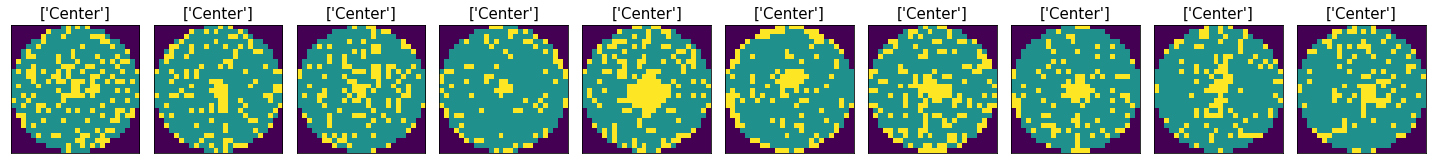

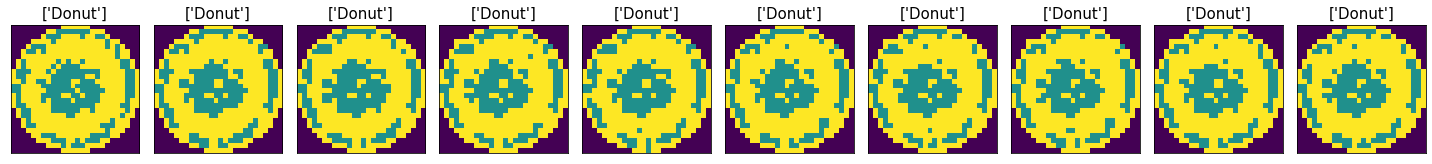

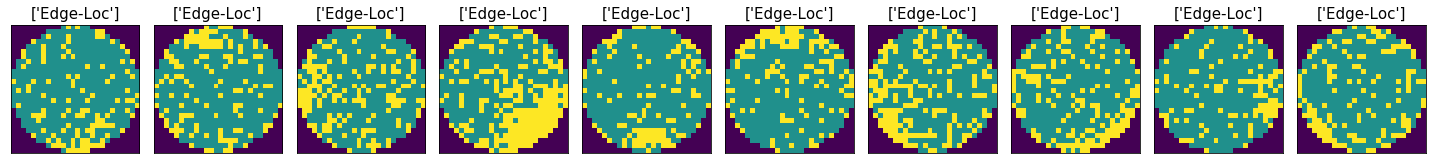

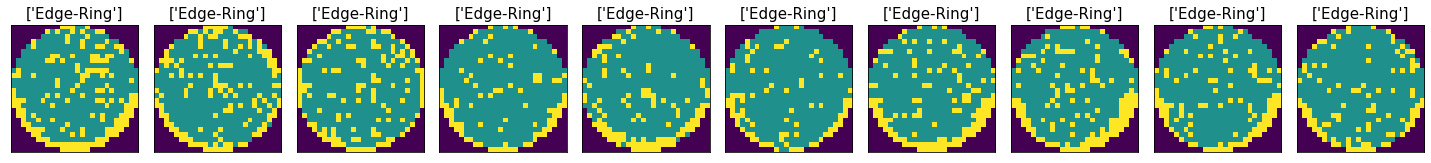

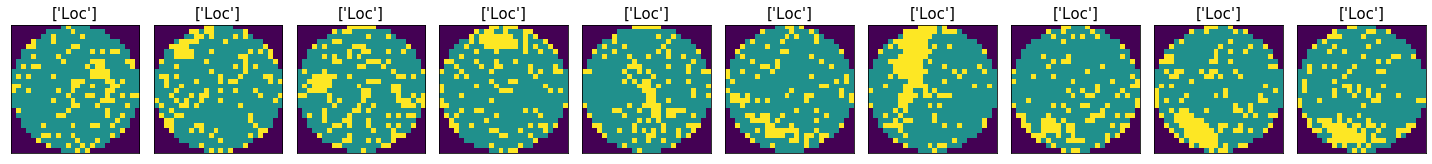

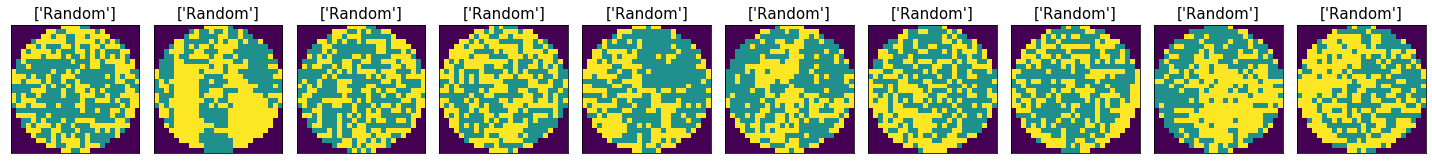

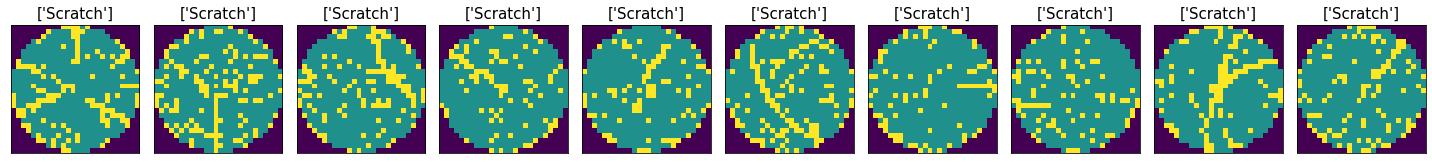

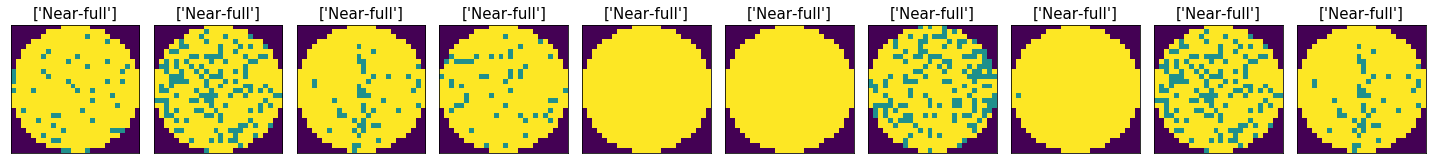

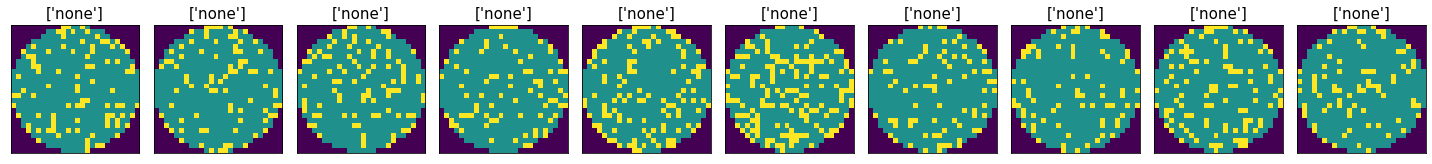

In [44]:
x = [0,1,2,3,4,5,6,7,8]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full','none']

for k in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(20, 20))
    ax = ax.ravel(order='C')
    for j in [k]:
        index = np.where(new_y==labels2[j])[0]
        img = new_x[index]
        #img = new_x[0:10]
        for i in range(10):
            ax[i].imshow(np.argmax(img[i+0], axis=2))
            ax[i].set_title(new_y[index[i+0]], fontsize=15)
            #ax[i].set_xlabel(df_withpattern.index[img.index[i]], fontsize=10)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()
    plt.show() 

### 学習を行う
- 不良ラベルを0-8の9次元のベクトルとして表現する．
- one-hotエンコーディングを行っている．

- 保存/読み込み

In [45]:
MAKE_DATASET = True
ver = 'shawon' if shawon else 'propose'
if MAKE_DATASET:
    pickle_dump(new_x, './data/new_x_' + ver + '.pickle')
    pickle_dump(new_y, './data/new_y_' + ver + '.pickle')
    pickle_dump(label_list, './data/label_list_' + ver + '.pickle')
    
if not MAKE_DATASET:
    new_x = pickle_load('./data/new_x_' + ver + '.pickle')
    new_y = pickle_load('./data/new_y_' + ver + '.pickle')
    label_list = pickle_load('./data/label_list_' + ver + '.pickle')

In [46]:
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i

In [47]:
for i in range(len(label_list)):
    label_list[i]['true_label'] = new_y[i][0]

In [48]:
# one-hot-encoding
new_y = to_categorical(new_y)

In [49]:
import random
random.seed(1)
def rand_ints_nodup(a, b, k):
    ns = []
    while len(ns) < k:
        n = random.randint(a, b)
        if not n in ns:
            ns.append(n)
    return ns

In [50]:
# testsize = 2000
# randlist = rand_ints_nodup(0, new_x.shape[0]-1, testsize)

# valx = new_x.copy()[randlist, :, :, :]
# valy = y.copy()[randlist, :]

test_size = 705 #705
new_x_size = new_x.shape[0]
testlist = rand_ints_nodup(0, new_x_size-1, test_size)
trainlist = [i for i in range(new_x_size) if i != testlist]
new_X=new_x[trainlist]
new_Y=new_y[trainlist]
test_x=new_x[testlist]
test_y=new_y[testlist]

label_train = [label_list[i] for i in trainlist]
label_test = [label_list[i] for i in testlist]

test_x.shape

(705, 26, 26, 3)

In [51]:
new_X=new_x
new_Y=new_y

- 学習データとテストデータに分割する．

In [52]:
indices = np.array(range(new_X.shape[0]))

x_train, x_test, y_train, y_test, indices_train, indices_test = train_test_split(new_X, new_Y, indices,
                                                                test_size=0.33,
                                                                random_state=2020)

In [53]:
label_vali = [label_train[i] for i in indices_test.tolist()]
label_train = [label_train[i] for i in indices_train.tolist()]

In [54]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (13179, 26, 26, 3), y : (13179, 9)
Test x: (6492, 26, 26, 3), y : (6492, 9)


- 学習データ246635枚，テストデータ121477枚．

- モデルの定義を行う．

### CNN

In [55]:
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
def create_model():


    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

- 3-Fold Cross validationで分割して学習する．

In [56]:
model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=1024, verbose=1) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

Epoch 1/30
8786/8786 [==============================] - 2s 199us/step - loss: 2.6062 - accuracy: 0.2987
Epoch 2/30
8786/8786 [==============================] - 1s 99us/step - loss: 1.0575 - accuracy: 0.6278
Epoch 3/30
8786/8786 [==============================] - 1s 101us/step - loss: 0.5912 - accuracy: 0.7723
Epoch 4/30
8786/8786 [==============================] - 1s 102us/step - loss: 0.9407 - accuracy: 0.8123
Epoch 5/30
8786/8786 [==============================] - 1s 102us/step - loss: 0.5865 - accuracy: 0.8309
Epoch 6/30
8786/8786 [==============================] - 1s 102us/step - loss: 0.3858 - accuracy: 0.8870
Epoch 7/30
8786/8786 [==============================] - 1s 102us/step - loss: 0.2530 - accuracy: 0.9187
Epoch 8/30
8786/8786 [==============================] - 1s 102us/step - loss: 0.1687 - accuracy: 0.9521
Epoch 9/30
8786/8786 [==============================] - 1s 102us/step - loss: 0.1043 - accuracy: 0.9751
Epoch 10/30
8786/8786 [==============================] - 1s 102us

8786/8786 [==============================] - 1s 104us/step - loss: 0.0103 - accuracy: 0.9986
Epoch 19/30
8786/8786 [==============================] - 1s 104us/step - loss: 0.0104 - accuracy: 0.9976
Epoch 20/30
8786/8786 [==============================] - 1s 104us/step - loss: 0.0117 - accuracy: 0.9978
Epoch 21/30
8786/8786 [==============================] - 1s 104us/step - loss: 0.0078 - accuracy: 0.9985
Epoch 22/30
8786/8786 [==============================] - 1s 104us/step - loss: 0.0083 - accuracy: 0.9990
Epoch 23/30
8786/8786 [==============================] - 1s 105us/step - loss: 0.0058 - accuracy: 0.9990
Epoch 24/30
8786/8786 [==============================] - 1s 105us/step - loss: 0.0044 - accuracy: 0.9990
Epoch 25/30
8786/8786 [==============================] - 1s 105us/step - loss: 0.0056 - accuracy: 0.9985
Epoch 26/30
8786/8786 [==============================] - 1s 105us/step - loss: 0.0062 - accuracy: 0.9984
Epoch 27/30
8786/8786 [==============================] - 1s 104us/s

- Cross validiationによる精度は99.55%であった．

- Cross validationなしで学習する．

In [57]:
history = model.fit(x_train, y_train,
         validation_data=[x_test, y_test],
         epochs=epoch,
         batch_size=batch_size,
         verbose=1           
         )

Train on 13179 samples, validate on 6492 samples
Epoch 1/30
13179/13179 [==============================] - 2s 162us/step - loss: 1.8006 - accuracy: 0.4154 - val_loss: 1.3033 - val_accuracy: 0.4985
Epoch 2/30
13179/13179 [==============================] - 2s 123us/step - loss: 0.9168 - accuracy: 0.6944 - val_loss: 0.7714 - val_accuracy: 0.7651
Epoch 3/30
13179/13179 [==============================] - 2s 124us/step - loss: 0.4740 - accuracy: 0.8534 - val_loss: 0.3126 - val_accuracy: 0.9122
Epoch 4/30
13179/13179 [==============================] - 2s 124us/step - loss: 0.2348 - accuracy: 0.9297 - val_loss: 0.1476 - val_accuracy: 0.9627
Epoch 5/30
13179/13179 [==============================] - 2s 123us/step - loss: 0.0987 - accuracy: 0.9759 - val_loss: 0.0698 - val_accuracy: 0.9797
Epoch 6/30
13179/13179 [==============================] - 2s 125us/step - loss: 0.0453 - accuracy: 0.9891 - val_loss: 0.0318 - val_accuracy: 0.9941
Epoch 7/30
13179/13179 [==============================] - 2s 12

### 結果のラベル付け

In [58]:
y_train_pred = model.predict(x_train)
y_train_max = np.argmax(y_train, axis=1)
failure = np.where(y_train_pred != y_train_max)[0]
failure = list(failure)
for i in failure:
    label_train[i]['predict_label'] = y_train_pred[i]

13179/13179 [==============================] - 0s 37us/step


- テストデータで評価．    

In [59]:
score = model.score(x_test, y_test)
#print('Test Loss:', score[0])
#print('Test accuracy:', score[1])
print('Testing Accuracy:',score)

6492/6492 [==============================] - 0s 39us/step
Testing Accuracy: 0.996303141117096


In [60]:
y_test_pred = model.predict(x_test)
y_test_max = np.argmax(y_test, axis=1)
failure = np.where(y_test_pred != y_test_max)[0]
failure = list(failure)
print('Number of failure ' + str(len(failure)))

6492/6492 [==============================] - 0s 36us/step
Number of failure 24


faulty case : none
predict label : Loc
{'wafer_id': '003472', 'true_label': '8', 'predict_label': 4, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 1}


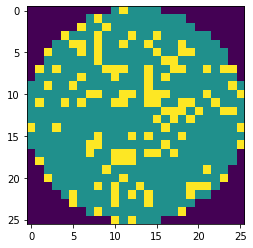

faulty case : Edge-Loc
predict label : Edge-Ring
{'wafer_id': '000233', 'true_label': '2', 'predict_label': 3, 'augmentation': {'noise': 7, 'rotation': 0, 'inversion': 0}, 'trials': 1}


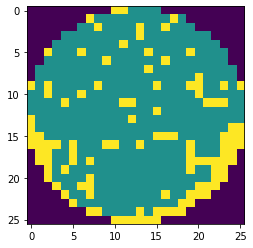

faulty case : Loc
predict label : Center
{'wafer_id': '000144', 'true_label': '4', 'predict_label': 0, 'augmentation': {'noise': 7, 'rotation': 0, 'inversion': 0}, 'trials': 1}


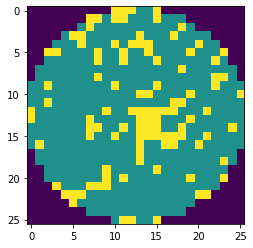

faulty case : none
predict label : Loc
{'wafer_id': '000377', 'true_label': '8', 'predict_label': 4, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 1}


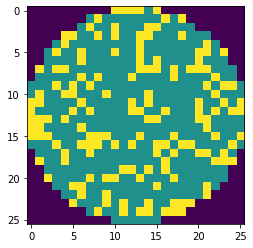

faulty case : none
predict label : Loc
{'wafer_id': '009935', 'true_label': '8', 'predict_label': 4, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 1}


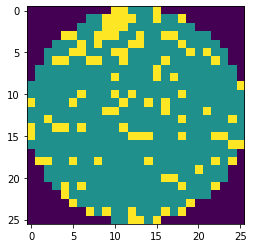

faulty case : Loc
predict label : Center
{'wafer_id': '009706', 'true_label': '4', 'predict_label': 0, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 1}


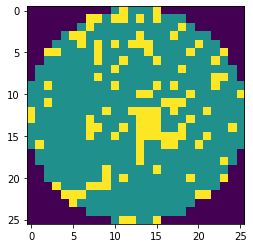

faulty case : none
predict label : Edge-Loc
{'wafer_id': '004098', 'true_label': '8', 'predict_label': 2, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 1}


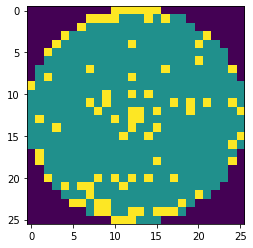

faulty case : none
predict label : Loc
{'wafer_id': '008020', 'true_label': '8', 'predict_label': 4, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 1}


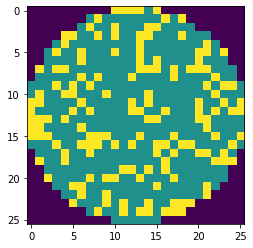

faulty case : none
predict label : Center
{'wafer_id': '012266', 'true_label': '8', 'predict_label': 0, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 1}


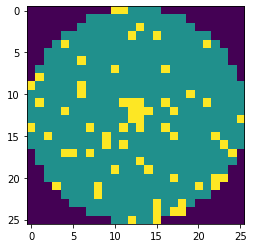

faulty case : none
predict label : Edge-Loc
{'wafer_id': '006807', 'true_label': '8', 'predict_label': 2, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 1}


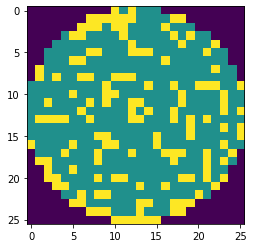

faulty case : Edge-Loc
predict label : Edge-Ring
{'wafer_id': '009137', 'true_label': '2', 'predict_label': 3, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 1}


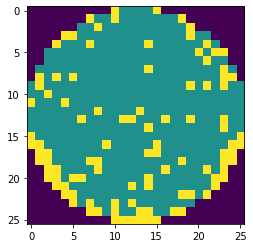

faulty case : Edge-Loc
predict label : none
{'wafer_id': '011433', 'true_label': '2', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 1}


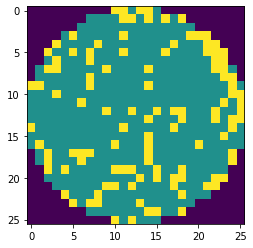

faulty case : none
predict label : Scratch
{'wafer_id': '014278', 'true_label': '8', 'predict_label': 7, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 1}


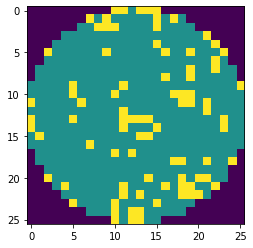

faulty case : none
predict label : Edge-Loc
{'wafer_id': '005330', 'true_label': '8', 'predict_label': 2, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 1}


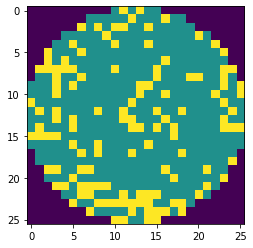

faulty case : Edge-Loc
predict label : none
{'wafer_id': '010536', 'true_label': '2', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 1}


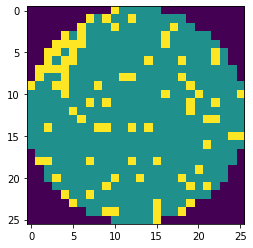

faulty case : Loc
predict label : none
{'wafer_id': '009141', 'true_label': '4', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 1}


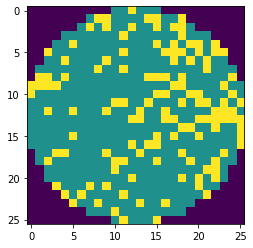

faulty case : none
predict label : Loc
{'wafer_id': '006740', 'true_label': '8', 'predict_label': 4, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 1}


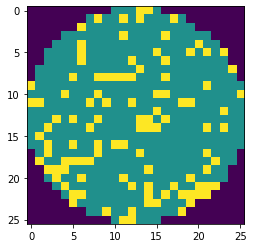

faulty case : Loc
predict label : none
{'wafer_id': '012071', 'true_label': '4', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 1}


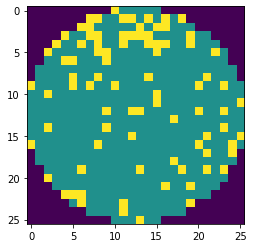

faulty case : Edge-Loc
predict label : Edge-Ring
{'wafer_id': '000186', 'true_label': '2', 'predict_label': 3, 'augmentation': {'noise': 7, 'rotation': 0, 'inversion': 0}, 'trials': 1}


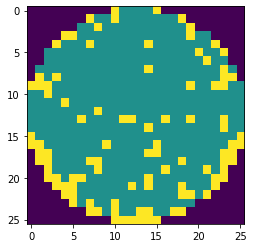

faulty case : none
predict label : Edge-Loc
{'wafer_id': '007682', 'true_label': '8', 'predict_label': 2, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 1}


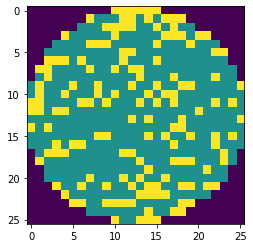

faulty case : none
predict label : Center
{'wafer_id': '005472', 'true_label': '8', 'predict_label': 0, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 1}


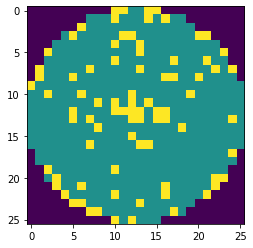

faulty case : none
predict label : Edge-Loc
{'wafer_id': '003732', 'true_label': '8', 'predict_label': 2, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 1}


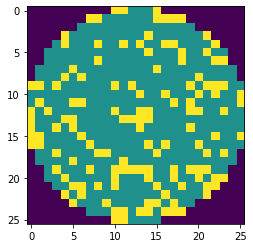

faulty case : none
predict label : Loc
{'wafer_id': '012911', 'true_label': '8', 'predict_label': 4, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 1}


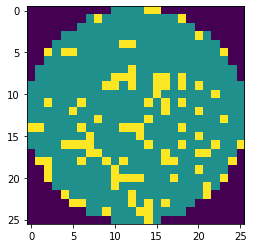

faulty case : Center
predict label : Loc
{'wafer_id': '000009', 'true_label': '0', 'predict_label': 4, 'augmentation': {'noise': 23, 'rotation': 0, 'inversion': 0}, 'trials': 1}


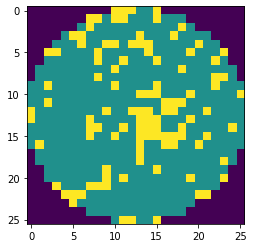

In [61]:
for i in failure:
    fig = plt.figure()
    plt.imshow(np.argmax(x_test[i], axis=2))
    print('faulty case : {}'.format(faulty_case_dict[np.argmax(y_test[i])]))
    print('predict label : {}'.format(faulty_case_dict[y_test_pred[i]]))
    label_vali[i]['predict_label'] = y_test_pred[i]
    print(label_vali[i])
    plt.show()
    
    img_name = '_'.join(map(str, label_vali[i].values())) + 'validation'
    fig.savefig('./img/' + ver + '_v1/' + img_name)

- acuurayは99.70%であった．

- 705枚のテストデータで評価

In [62]:
score = model.score(test_x, test_y)
#print('Test Loss:', score[0])
#print('Test accuracy:', score[1])
print('Testing Accuracy:',score)

705/705 [==============================] - 0s 185us/step
Testing Accuracy: 0.9971631169319153


In [63]:
test_y_pred = model.predict(test_x)
test_y_max = np.argmax(test_y, axis=1)
failure = np.where(test_y_pred != test_y_max)[0]
failure = list(failure)
print('Number of failure ' + str(len(failure)))

705/705 [==============================] - 0s 40us/step
Number of failure 2


faulty case : Edge-Loc
predict label : Edge-Ring
{'wafer_id': '000186', 'true_label': '2', 'predict_label': 3, 'augmentation': {'noise': 7, 'rotation': 0, 'inversion': 0}, 'trials': 1}


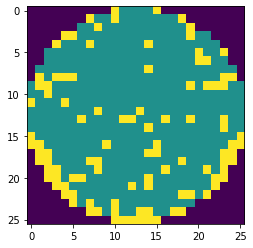

faulty case : Edge-Loc
predict label : Edge-Ring
{'wafer_id': '000186', 'true_label': '2', 'predict_label': 3, 'augmentation': {'noise': 7, 'rotation': 0, 'inversion': 0}, 'trials': 1}


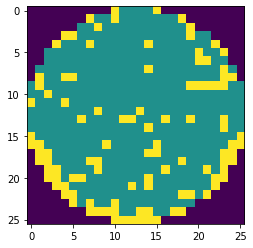

In [64]:
for i in failure:
    fig = plt.figure()
    plt.imshow(np.argmax(test_x[i], axis=2))
    print('faulty case : {}'.format(faulty_case_dict[np.argmax(test_y[i])]))
    print('predict label : {}'.format(faulty_case_dict[test_y_pred[i]]))
    label_test[i]['predict_label'] = test_y_pred[i]
    print(label_test[i])
    plt.show()
    
    img_name = '_'.join(map(str, label_test[i].values())) + 'test'
    fig.savefig('./img/' + ver + '_v1/' + img_name)

- モデルは以下．
    - 入力層
    - 畳み込み層3つ
    - Flatten層（1次元に）
    - 全結合層3つ

In [65]:
model.model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 26, 26, 3)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 26, 26, 16)        448       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 26, 26, 64)        9280      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 26, 26, 128)       73856     
_________________________________________________________________
flatten_4 (Flatten)          (None, 86528)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               44302848  
_________________________________________________________________
dense_11 (Dense)             (None, 128)               6566

- accuracyグラフ，lossグラフは以下．
- 5epoch程度で落ち着いている．

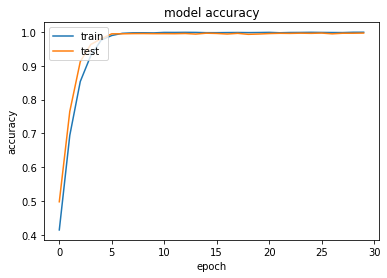

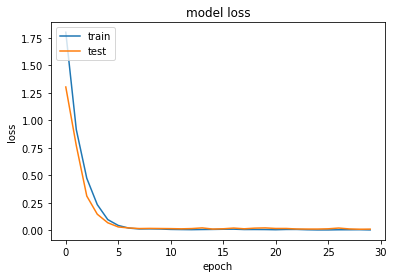

In [66]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [67]:
#y_train_pred = np.argmax(model.predict(x_train))
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
y_train_max = np.argmax(y_train, axis=1)
y_test_max = np.argmax(y_test, axis=1)
test_y_pred = model.predict(test_x)
test_y_max = np.argmax(test_y, axis=1)

print(y_train_max[0])
print(y_train_pred[0])

train_acc2 = np.sum(y_train_max == y_train_pred, axis=0, dtype='float') / x_train.shape[0]
test_acc2 = np.sum(y_test_max == y_test_pred, axis=0, dtype='float') / x_test.shape[0]
print('Training acc: {}'.format(train_acc2*100))
print('Testing acc: {}'.format(test_acc2*100))
print("y_train_pred[:100]: ", y_train_pred[:100])
print ("y_train_max[:100]: ", y_train_max[:100])

705/705 [==============================] - 0s 37us/step
7
7
Training acc: 99.88618256316867
Testing acc: 99.63031423290202
y_train_pred[:100]:  [7 0 5 7 4 4 4 5 7 2 8 1 0 6 7 2 6 0 4 6 6 6 8 7 1 6 5 7 2 0 8 6 3 5 0 8 3
 1 8 7 4 5 8 2 5 3 8 0 3 8 3 5 5 0 5 7 1 2 1 8 4 6 7 6 5 5 3 6 4 5 6 8 7 7
 6 0 1 1 7 4 3 6 7 2 6 5 1 5 8 8 8 0 7 5 1 2 8 8 0 7]
y_train_max[:100]:  [7 0 5 7 4 4 4 5 7 2 8 1 0 6 7 2 6 0 4 6 6 6 8 7 1 6 5 7 2 0 8 6 3 5 0 8 3
 1 8 7 4 5 8 2 5 3 8 0 3 8 3 5 5 0 5 7 1 2 1 8 4 6 7 6 5 5 3 6 4 5 6 8 7 7
 6 0 1 1 7 4 3 6 7 2 6 5 1 5 8 8 8 0 7 5 1 2 8 8 0 7]


### 混同行列

In [68]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7 ,8], ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Random", "Scratch", "Near-full", "None"])
    plt.yticks([0, 1, 2, 3, 4, 5, 6, 7 ,8], ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Random", "Scratch", "Near-full", "None"])
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

- validation confmat

Confusion matrix, without normalization
Normalized confusion matrix


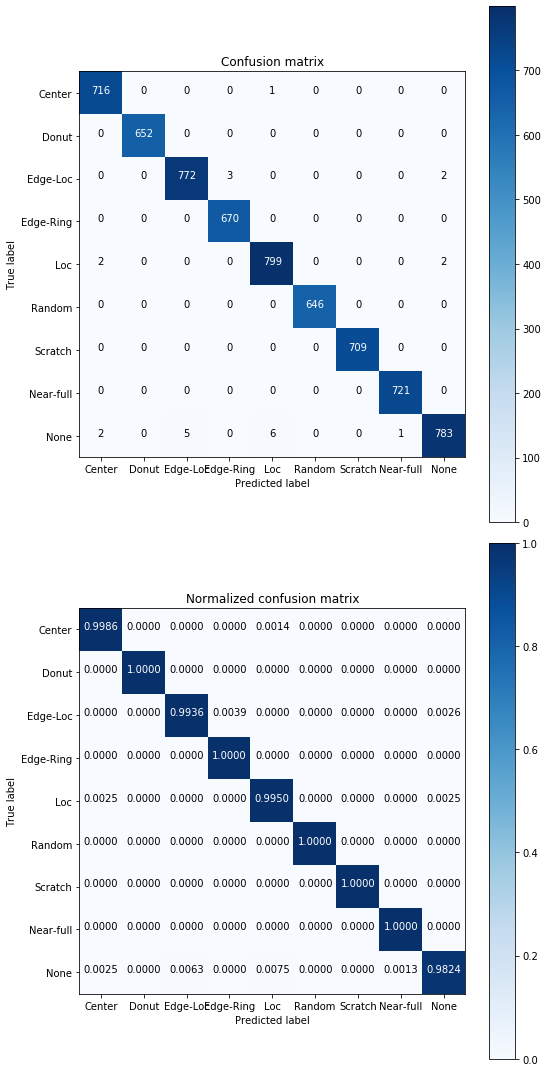

In [69]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_max, y_test_pred)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(8, 15)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()

- test confmat

Confusion matrix, without normalization
Normalized confusion matrix


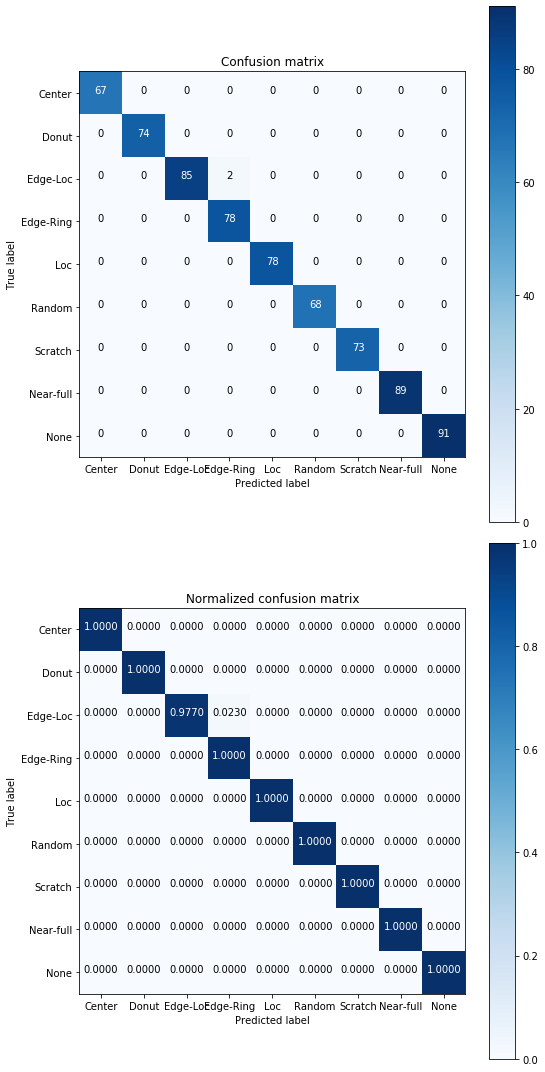

In [70]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y_max, test_y_pred)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(8, 15)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()